# 5CIENCE_V1

## 0 - IMPORTS AND FUNCTIONS

In [1]:
import warnings
import inflection
import pandas                                       as pd
import lightgbm                                     as lgbm
from sklearn                 import neighbors       as nh
from sklearn                 import model_selection as ms
from xgboost                 import XGBClassifier
from sklearn.metrics         import precision_score 

from sklearn                 import preprocessing   as pp
mms_age = pp.MinMaxScaler()

from sklearn.preprocessing   import OrdinalEncoder
oenc = OrdinalEncoder()

import numpy as np
import seaborn as sns
from matplotlib import pyplot

warnings.filterwarnings( 'ignore' )

### 0.1 - FUNCOES DE AUXILIO

In [79]:
def ml_performance( model_name, precision_atK):
    return pd.DataFrame( {'Model Name': model_name,
                          'Precision_at_K': precision_atK}, index=[0])

## 1 - DATA LOAD & DATA DESCRIPTIVE

In [91]:
# All Data - Windows
# df_raw = pd.read_csv('C:/Users/perot/Documents/ds_repos/hackday_5/Hackday_InStyle_Promoter_Score/data/train.csv')

path = "./Data/"
df_raw = pd.read_csv(path + 'train.csv')

In [92]:
df_raw.head()

,id,Gender,Customer Type,Age,Type of Purchase,Store size,Store distance,InStore wifi,Open/Close time convenient,Easy of online shopping,...,Kids entertainment,Seller service,Showroom,Self-Store,Purchase service,Store Service,Cleanliness,Carrier delay in minutes,Delivery delay in minutes,Satisfaction
0,70172,Male,Loyal Customer,13,Personal,Small,460,3,4,3,...,5,4,3,4,4,5,5,25,18.0,Neutral or Dissatisfaction
1,5047,Male,disloyal Customer,25,Gift,Large,235,3,2,3,...,1,1,5,3,1,4,1,1,6.0,Neutral or Dissatisfaction
2,110028,Female,Loyal Customer,26,Gift,Large,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,Satisfied
3,24026,Female,Loyal Customer,25,Gift,Large,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,Neutral or Dissatisfaction
4,119299,Male,Loyal Customer,61,Gift,Large,214,3,3,3,...,3,3,4,4,3,3,3,0,0.0,Satisfied


### 1.1 - SPLIT DATASET INTO TRAINING, TEST AND VALIDATION

In [93]:
## Renomeando as colunas, removendo letras maiusculas e substituindo espacos por _
cols_old = ['id', 'Gender', 'Customer Type', 'Age', 'Type of Purchase','Store size', 'Store distance', 'InStore wifi',
            'Open/Close time convenient', 'Easy of online shopping', 'Store location', 'Toilet cleaning', 'Dressing room', 
            'Waiting room','Kids entertainment', 'Seller service', 'Showroom ', 'Self-Store', 'Purchase service', 
            'Store Service', 'Cleanliness', 'Carrier delay in minutes', 'Delivery delay in minutes', 'Satisfaction']

snakecase = lambda x: inflection.underscore(x.replace(' ', '_'))
cols_new = list( map( snakecase, cols_old ) )

df_raw.columns = cols_new

In [94]:
# Filtrando Outliers
df_raw_log = df_raw.query('carrier_delay_in_minutes < 257') # linhas excluidas 398

In [ ]:
# Dividindo o dataset em treino e validacao 80% / 20%
X = df_raw.drop( 'satisfaction', axis=1 )
y = df_raw['satisfaction'].copy()
x_train, x_valid, y_train, y_valid = ms.train_test_split( X, y, test_size=0.2 )

print(f" x_train: {x_train.shape}\n y_train: {y_train.shape}\n x_valid: {x_valid.shape}\n y_valid: {y_valid.shape}\n")

In [95]:
# Dividindo o dataset em treino e validacao 80% / 20%
X = df_raw_log.drop( 'satisfaction', axis=1 )
y = df_raw_log['satisfaction'].copy()
x_train_log, x_valid_log, y_train_log, y_valid_log = ms.train_test_split( X, y, test_size=0.2 )

print(f"x_train_log: {x_train_log.shape}\n y_train_log: {y_train_log.shape}\n x_valid_log: {x_valid_log.shape}\n y_valid_log: {y_valid_log.shape}\n")

x_train_log: (82804, 23)
 y_train_log: (82804,)
 x_valid_log: (20701, 23)
 y_valid_log: (20701,)



## 1 - FEATURE ENGINEERING

### 1.0 Com os Outliers

In [ ]:
# Preenchendo dados nulos
x_train['delivery_delay_in_minutes'] = x_train['delivery_delay_in_minutes'].fillna(0)
x_valid['delivery_delay_in_minutes'] = x_valid['delivery_delay_in_minutes'].fillna(0)

In [ ]:
# # Ajuste coluna gender para 1 mulher e 0 homem
# x_train['gender'] = x_train['gender'].apply(lambda x: 1 if(x =='Female') else 0)

# Gender Percentage (Porcentagem de homens e mulheres)
fe_gender = x_train.groupby('gender').size() / len(x_train)
x_train['gender'] = x_train['gender'].map( fe_gender )

# # Ajuste coluna customer_type para 1 loyal e 0 disloyal
# x_train['customer_type'] = x_train['customer_type'].apply(lambda x: 1 if(x =='Loyal Customer') else 0)

# customer_type - Frequency Encoding / Target Encoding / Weighted Targed Encoding
fe_customer_type = x_train.groupby( 'customer_type').size() / len( x_train )
x_train['customer_type'] = x_train['customer_type'].map( fe_customer_type )

# # Ajuste coluna type_of_purchase para Gift = 1 e Personal = 0
# x_train['type_of_purchase'] = x_train['type_of_purchase'].apply(lambda x: 1 if(x =='Gift') else 0)

# type_of_purchase - Frequency Encoding / Target Encoding
fe_type_of_purchase = x_train.groupby( 'type_of_purchase' ).size() / len( x_train ) 
x_train['type_of_purchase'] = x_train['type_of_purchase'].map( fe_type_of_purchase )

# Ajuste coluna customer_type para 1 loyal e 0 disloyal
x_train['store_size'] = x_train['store_size'].apply(lambda x: 2 if(x =='Large') else 1 if(x == 'Medium') else 0)

# Criando coluna Faixa_Etaria
x_train['age_range'] = x_train['age'].apply(lambda x: 1 if x <= 18 else
                                            2 if ((x > 18) and (x <= 30)) else
                                            3 if (x > 30) and (x <= 50) else 
                                            4 if (x > 50) and (x <= 70) else 5
                                            ) 

# Age
x_train['age'] = mms_age.fit_transform( x_train[['age']].values )


# Store Size
x_train['store_size'] = oenc.fit_transform( x_train[['store_size']].values )


In [ ]:
# # Ajuste coluna gender para 1 mulher e 0 homem
# x_valid['gender'] = x_valid['gender'].apply(lambda x: 1 if(x =='Female') else 0)

# Gender 
fe_gender = x_valid.groupby('gender').size() / len(x_valid)
x_valid['gender'] = x_valid['gender'].map( fe_gender )

# # Ajuste coluna customer_type para 1 loyal e 0 disloyal
# x_valid['customer_type'] = x_valid['customer_type'].apply(lambda x: 1 if(x =='Loyal Customer') else 0)

# customer_type - Frequency Encoding / Target Encoding / Weighted Targed Encoding
fe_customer_type = x_valid.groupby( 'customer_type').size() / len( x_valid )
x_valid['customer_type'] = x_valid['customer_type'].map( fe_customer_type )

# # Ajuste coluna type_of_purchase para Gift = 1 e Personal = 0
# x_valid['type_of_purchase'] = x_valid['type_of_purchase'].apply(lambda x: 1 if(x =='Gift') else 0)

# type_of_purchase - Frequency Encoding / Target Encoding
fe_type_of_purchase = x_valid.groupby( 'type_of_purchase' ).size() / len( x_valid ) 
x_valid['type_of_purchase'] = x_valid['type_of_purchase'].map( fe_type_of_purchase )

# Ajuste coluna customer_type para 1 loyal e 0 disloyal
x_valid['store_size'] = x_valid['store_size'].apply(lambda x: 2 if(x =='Large') else 1 if(x == 'Medium') else 0)

# Criando coluna Faixa_Etaria
x_valid['age_range'] = x_valid['age'].apply(lambda x: 1 if x <= 18 else
                                            2 if ((x > 18) and (x <= 30)) else
                                            3 if (x > 30) and (x <= 50) else 
                                            4 if (x > 50) and (x <= 70) else 5
                                            )       

# Age
x_valid['age'] = mms_age.fit_transform( x_valid[['age']].values )


# Store Size
x_valid['store_size'] = oenc.fit_transform( x_valid[['store_size']].values )                                                                                                                                                                                                        

In [ ]:
# Ajuste do dataset com a variavel resposta
y_train = y_train.apply(lambda x: 1 if(x=='Satisfied') else 0)
y_valid = y_valid.apply(lambda x: 1 if(x=='Satisfied') else 0)

### 1.1 Tratando Outlier

<font color='orange'>Ultimas Transformações inclusas</font>

In [96]:
# Preenchendo dados nulos
x_train_log['delivery_delay_in_minutes'] = x_train_log['delivery_delay_in_minutes'].fillna(0)
x_valid_log['delivery_delay_in_minutes'] = x_valid_log['delivery_delay_in_minutes'].fillna(0)

# Gender Percentage (Porcentagem de homens e mulheres)
fe_gender = x_train_log.groupby('gender').size() / len(x_train_log)
x_train_log['gender'] = x_train_log['gender'].map( fe_gender )

# customer_type - Frequency Encoding / Target Encoding / Weighted Targed Encoding
fe_customer_type = x_train_log.groupby( 'customer_type').size() / len( x_train_log )
x_train_log['customer_type'] = x_train_log['customer_type'].map( fe_customer_type )

# type_of_purchase - Frequency Encoding / Target Encoding
fe_type_of_purchase = x_train_log.groupby( 'type_of_purchase' ).size() / len( x_train_log ) 
x_train_log['type_of_purchase'] = x_train_log['type_of_purchase'].map( fe_type_of_purchase )

# Ajuste coluna customer_type para 1 loyal e 0 disloyal
x_train_log['store_size'] = x_train_log['store_size'].apply(lambda x: 2 if(x =='Large') else 1 if(x == 'Medium') else 0)

# Criando coluna Faixa_Etaria
x_train_log['age_range'] = x_train_log['age'].apply(lambda x: 1 if x <= 18 else
                                            2 if ((x > 18) and (x <= 30)) else
                                            3 if (x > 30) and (x <= 50) else 
                                            4 if (x > 50) and (x <= 70) else 5
                                            ) 

# Age
x_train_log['age'] = mms_age.fit_transform( x_train_log[['age']].values )

# Store Size
x_train_log['store_size'] = oenc.fit_transform( x_train_log[['store_size']].values )

########### 

# Gender 
fe_gender = x_valid_log.groupby('gender').size() / len(x_valid_log)
x_valid_log['gender'] = x_valid_log['gender'].map( fe_gender )

# customer_type - Frequency Encoding / Target Encoding / Weighted Targed Encoding
fe_customer_type = x_valid_log.groupby( 'customer_type').size() / len( x_valid_log )
x_valid_log['customer_type'] = x_valid_log['customer_type'].map( fe_customer_type )

# type_of_purchase - Frequency Encoding / Target Encoding
fe_type_of_purchase = x_valid_log.groupby( 'type_of_purchase' ).size() / len( x_valid_log ) 
x_valid_log['type_of_purchase'] = x_valid_log['type_of_purchase'].map( fe_type_of_purchase )

# Ajuste coluna customer_type para 1 loyal e 0 disloyal
x_valid_log['store_size'] = x_valid_log['store_size'].apply(lambda x: 2 if(x =='Large') else 1 if(x == 'Medium') else 0)

# Criando coluna Faixa_Etaria
x_valid_log['age_range'] = x_valid_log['age'].apply(lambda x: 1 if x <= 18 else
                                            2 if ((x > 18) and (x <= 30)) else
                                            3 if (x > 30) and (x <= 50) else 
                                            4 if (x > 50) and (x <= 70) else 5
                                            )       

# Age
x_valid_log['age'] = mms_age.fit_transform( x_valid_log[['age']].values )


# Store Size
x_valid_log['store_size'] = oenc.fit_transform( x_valid_log[['store_size']].values )                                                                                                                                                                                                        

# Ajuste do dataset com a variavel resposta
y_train_log = y_train_log.apply(lambda x: 1 if(x=='Satisfied') else 0)
y_valid_log = y_valid_log.apply(lambda x: 1 if(x=='Satisfied') else 0)

<Axes: xlabel='carrier_delay_in_minutes', ylabel='Density'>

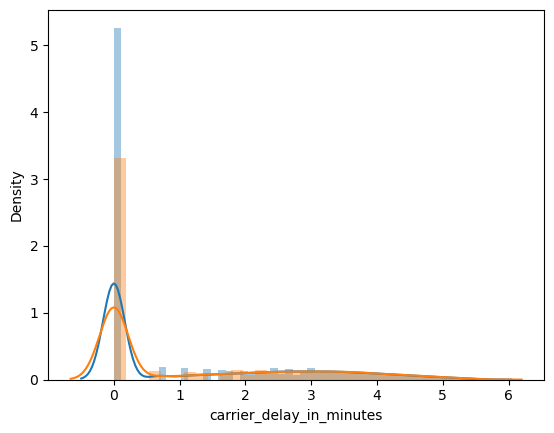

In [97]:
x_train_log['carrier_delay_in_minutes'] = x_train_log['carrier_delay_in_minutes'].apply(lambda x: np.log(x) if x > 0 else x)   

sns.distplot( x_train_log['carrier_delay_in_minutes'], kde=True )



x_valid_log['carrier_delay_in_minutes'] = x_valid_log['carrier_delay_in_minutes'].apply(lambda x: np.log(x) if x > 0 else x)   

sns.distplot( x_valid_log['carrier_delay_in_minutes'], kde=True )

 ### DROPAR COLUNAS ALTAMENTE RELACIONADAS

In [ ]:
drop_col = ['id','in_store_wifi', 'dressing_room', 'store_size']

In [ ]:
x_training_drop = x_train.drop(drop_col, axis=1)
x_validation_drop = x_valid.drop(drop_col, axis=1)

In [85]:
drop_col_1 = ['id','in_store_wifi', 'dressing_room', 'store_size','delivery_delay_in_minutes','waiting_room', 'kids_entertainment', 'seller_service']

drop_col_2 = ['id', 'in_store_wifi', 'dressing_room', 'delivery_delay_in_minutes', 'waiting_room', 'kids_entertainment', 'seller_service']

In [ ]:
x_training_drop_1 = x_train.drop(drop_col_1, axis=1)
x_validation_drop_1 = x_valid.drop(drop_col_1, axis=1)

In [86]:
x_training_drop_1_log = x_train_log.drop(drop_col_1, axis=1)
x_validation_drop_1_log = x_valid_log.drop(drop_col_1, axis=1)

<font color='orange'>rodando com as transformações nas features</font>

In [52]:
# x_training_drop_1_log_feature = x_train_log.drop(drop_col_1, axis=1)
# x_validation_drop_1_log_feature = x_valid_log.drop(drop_col_1, axis=1)

x_training_drop_1_log_feature = x_train_log.drop(drop_col_2, axis=1)
x_validation_drop_1_log_feature = x_valid_log.drop(drop_col_2, axis=1)

## 7 - ML MODELS TRAINING

#### 7.1.1 - XGB Model

##### 7.1.1.1 - Sem nenhuma trativa

In [ ]:
# model definition
xgb_model = XGBClassifier()

# model training
xgb_model.fit( x_train, y_train )

# model prediction - Check if the model perform well
yhat_xgb = xgb_model.predict( x_valid )

In [ ]:
xgb_precision = precision_score(y_valid, yhat_xgb, average='micro') 
xgb_performance = ml_performance('XGB', xgb_precision)

<font color='orange'>rodei sem dropar, considerando as novas features e o log</font>

In [100]:
# model definition
xgb_model = XGBClassifier()

# model training
xgb_model.fit( x_train_log, y_train_log )

# model prediction - Check if the model perform well
yhat_xgb = xgb_model.predict( x_valid_log )

In [101]:
xgb_precision = precision_score(y_valid_log, yhat_xgb, average='micro') 
xgb_performance = ml_performance('XGB', xgb_precision)

##### 7.1.1.2 - Dropando as colunas -> ('id','in_store_wifi', 'dressing_room', 'store_size') 

In [ ]:
# model definition
xgb_model_drop = XGBClassifier()

# model training
xgb_model_drop.fit( x_training_drop, y_train )

# model prediction - Check if the model perform well
yhat_xgb_drop = xgb_model_drop.predict( x_validation_drop )

In [ ]:
xgb_precision_drop = precision_score(y_valid, yhat_xgb_drop, average='micro') 
xgb_performance_drop = ml_performance('XGB', xgb_precision_drop)

##### 7.1.1.3 - Dropando as colunas -> ('id','in_store_wifi', 'dressing_room', 'store_size','delivery_delay_in_minutes','waiting_room', 'kids_entertainment', 'seller_service') 

In [ ]:
# model definition
xgb_model_drop_1 = XGBClassifier()

# model training
xgb_model_drop_1.fit( x_training_drop_1, y_train )

# model prediction - Check if the model perform well
yhat_xgb_drop_1 = xgb_model_drop_1.predict( x_validation_drop_1 )

In [ ]:
xgb_precision_drop_1 = precision_score(y_valid, yhat_xgb_drop_1, average='micro') 
xgb_performance_drop_1 = ml_performance('XGB', xgb_precision_drop_1)

##### 7.1.1.4 - 7.1.1.3 + Trativa Outliers (Log)

In [ ]:
# model definition
xgb_model_drop_1_log = XGBClassifier()

# model training
xgb_model_drop_1_log.fit( x_training_drop_1_log, y_train_log )

# model prediction - Check if the model perform well
yhat_xgb_drop_1_log = xgb_model_drop_1_log.predict( x_validation_drop_1_log )

In [ ]:
xgb_precision_drop_1_log = precision_score(y_valid_log, yhat_xgb_drop_1_log, average='micro') 
xgb_performance_drop_1_log = ml_performance('XGB', xgb_precision_drop_1_log)

##### 7.1.1.5 - 7.1.1.3 + Trativa Outliers (Log) + Features <font color='orange'>rodei</font>

In [69]:
# model definition
xgb_model_drop_1_log_feature = XGBClassifier()

# model training
xgb_model_drop_1_log_feature.fit( x_training_drop_1_log_feature, y_train_log )

# model prediction - Check if the model perform well
yhat_xgb_drop_1_log_feature = xgb_model_drop_1_log_feature.predict( x_validation_drop_1_log_feature )

In [70]:
xgb_precision_drop_1_log = precision_score(y_valid_log, yhat_xgb_drop_1_log_feature, average='micro') 
xgb_performance_drop_1_log_feature = ml_performance('XGB', xgb_precision_drop_1_log)

#### 7.1.2 - KNN

##### 7.1.2.1 - Sem nenhuma tratativa

In [ ]:
# model definition
knn_model = nh.KNeighborsClassifier( n_neighbors=8 )

# model training
knn_model.fit( x_train, y_train )

# model prediction - The generalization POWER
yhat_knn = knn_model.predict( x_valid )

In [ ]:
knn_precision = precision_score(y_valid, yhat_knn, average='micro') 
KNN_performance = ml_performance('KNN', knn_precision) 

<font color='orange'>rodei sem dropar, considerando as novas features e o log</font>

In [102]:
# model definition
knn_model = nh.KNeighborsClassifier( n_neighbors=8 )

# model training
knn_model.fit( x_train_log, y_train_log )

# model prediction - The generalization POWER
yhat_knn = knn_model.predict( x_valid_log )

In [103]:
knn_precision = precision_score(y_valid_log, yhat_knn, average='micro') 
KNN_performance = ml_performance('KNN', knn_precision) 

##### 7.1.2.2 - Dropando as colunas -> ('id','in_store_wifi', 'dressing_room', 'store_size') 

In [ ]:
# model definition
knn_model_drop = nh.KNeighborsClassifier( n_neighbors=8 )

# model training
knn_model_drop.fit( x_training_drop, y_train )

# model prediction - The generalization POWER
yhat_knn_drop = knn_model_drop.predict( x_validation_drop )

In [ ]:
knn_precision_drop = precision_score(y_valid, yhat_knn_drop, average='micro') 
knn_performance_drop = ml_performance('KNN', knn_precision_drop)

##### 7.1.2.3 - Dropando as colunas -> ('id','in_store_wifi', 'dressing_room', 'store_size','delivery_delay_in_minutes','waiting_room', 'kids_entertainment', 'seller_service') 

In [ ]:
# model definition
knn_model_drop_1 = nh.KNeighborsClassifier( n_neighbors=8 )

# model training
knn_model_drop_1.fit( x_training_drop_1, y_train )

# model prediction - The generalization POWER
yhat_knn_drop_1 = knn_model_drop_1.predict( x_validation_drop_1 )

In [ ]:
knn_precision_drop_1 = precision_score(y_valid, yhat_knn_drop_1, average='micro') 
knn_performance_drop_1 = ml_performance('KNN', knn_precision_drop_1)

##### 7.1.2.4 - 7.1.2.3 + Trativa Outliers (Log)

In [ ]:
# model definition
knn_model_drop_1_log = nh.KNeighborsClassifier( n_neighbors=8 )

# model training
knn_model_drop_1_log.fit( x_training_drop_1_log, y_train_log )

# model prediction - The generalization POWER
yhat_knn_drop_1_log = knn_model_drop_1_log.predict( x_validation_drop_1_log )

In [ ]:
knn_precision_drop_1_log = precision_score(y_valid_log, yhat_knn_drop_1_log, average='micro') 
knn_performance_drop_1_log = ml_performance('KNN', knn_precision_drop_1_log)

##### 7.1.2.5 - 7.1.1.3 + Trativa Outliers (Log) + Features <font color='orange'>rodei</font>

In [67]:
# model definition
knn_model_drop_1_log_feature = nh.KNeighborsClassifier( n_neighbors=8 )

# model training
knn_model_drop_1_log_feature.fit( x_training_drop_1_log_feature, y_train_log )

# model prediction - The generalization POWER
yhat_knn_drop_1_log_feature = knn_model_drop_1_log_feature.predict( x_validation_drop_1_log_feature )

In [68]:
knn_precision_drop_1_log = precision_score(y_valid_log, yhat_knn_drop_1_log_feature, average='micro') 
knn_performance_drop_1_log_feature = ml_performance('KNN', knn_precision_drop_1_log)

#### 7.1.3 - Light gradient Boostin Machine Classifier Model

##### 7.1.3.1 - Sem nenhuma tratativa

In [ ]:
# Model Definition
lgbm_model = lgbm.LGBMClassifier( learning_rate=0.09, max_depth=-5, random_state=42 )

# Model training
model_lgbm = lgbm_model.fit( x_train, y_train )

# Model Prediction
yhat_lgbm = model_lgbm.predict( x_valid )

In [ ]:
lgbm_precision = precision_score(y_valid, yhat_lgbm, average='micro') 
lgbm_performance = ml_performance('LGBM', lgbm_precision) 

<font color='orange'>rodei sem dropar, considerando as novas features e o log</font>

In [104]:
# Model Definition
lgbm_model = lgbm.LGBMClassifier( learning_rate=0.09, max_depth=-5, random_state=42 )

# Model training
model_lgbm = lgbm_model.fit( x_train_log, y_train_log )

# Model Prediction
yhat_lgbm = model_lgbm.predict( x_valid_log )

In [105]:
lgbm_precision = precision_score(y_valid_log, yhat_lgbm, average='micro') 
lgbm_performance = ml_performance('LGBM', lgbm_precision) 

##### 7.1.3.2 - Dropando as colunas -> ('id','in_store_wifi', 'dressing_room', 'store_size') 

In [ ]:
# Model Definition
lgbm_model_drop = lgbm.LGBMClassifier( learning_rate=0.09, max_depth=-5, random_state=42 )

# Model training
model_lgbm_drop = lgbm_model_drop.fit( x_training_drop, y_train )

# Model Prediction
yhat_lgbm_drop = model_lgbm_drop.predict( x_validation_drop )

In [ ]:
lgbm_precision_drop = precision_score(y_valid, yhat_lgbm_drop, average='micro') 
lgbm_performance_drop = ml_performance('LGBM', lgbm_precision_drop) 

##### 7.1.3.3 - Dropando as colunas -> ('id','in_store_wifi', 'dressing_room', 'store_size','delivery_delay_in_minutes','waiting_room', 'kids_entertainment', 'seller_service') 

In [ ]:
# Model Definition
lgbm_model_drop_1 = lgbm.LGBMClassifier( learning_rate=0.09, max_depth=-5, random_state=42 )

# Model training
model_lgbm_drop_1 = lgbm_model_drop_1.fit( x_training_drop_1, y_train )

# Model Prediction
yhat_lgbm_drop_1 = model_lgbm_drop_1.predict( x_validation_drop_1 )

In [ ]:
lgbm_precision_drop_1 = precision_score(y_valid, yhat_lgbm_drop_1, average='micro') 
lgbm_performance_drop_1 = ml_performance('LGBM', lgbm_precision_drop_1) 

##### 7.1.3.4 - 7.1.3.3 + Trativa Outliers (Log) <font color='orange'>rodei</font>

In [57]:
# Model Definition
lgbm_model_drop_1_log_feature = lgbm.LGBMClassifier( learning_rate=0.09, max_depth=-5, random_state=42 )

# Model training
model_lgbm_drop_1_log_feature = lgbm_model_drop_1_log_feature.fit( x_training_drop_1_log_feature, y_train_log )

# Model Prediction
yhat_lgbm_drop_1_log_feature = model_lgbm_drop_1_log_feature.predict( x_validation_drop_1_log_feature )

In [58]:
lgbm_precision_drop_1_feature = precision_score(y_valid_log, yhat_lgbm_drop_1_log_feature, average='micro') 
lgbm_performance_drop_1_log_feature = ml_performance('LGBM', lgbm_precision_drop_1_feature) 

# Performance dos Modelos

### Sem nenhuma tratativa <font color='orange'>rodei</font>

In [106]:
model_performance_base =pd.concat([xgb_performance, KNN_performance, lgbm_performance])
model_performance_base.sort_values('Precision_at_K', ascending= False)

,Model Name,Precision_at_K
0,LGBM,0.964205
0,XGB,0.963528
0,KNN,0.671175


### Dropando as colunas -> ('id','in_store_wifi', 'dressing_room', 'store_size') 

In [ ]:
model_performance_drop =pd.concat([xgb_performance_drop, knn_performance_drop, lgbm_performance_drop])
model_performance_drop.sort_values('Precision_at_K', ascending= False)

### Dropando as colunas -> ('id','in_store_wifi', 'dressing_room', 'store_size','delivery_delay_in_minutes','waiting_room', 'kids_entertainment', 'seller_service') 

In [ ]:
model_performance_drop_1 =pd.concat([xgb_performance_drop_1, knn_performance_drop_1, lgbm_performance_drop_1])
model_performance_drop_1.sort_values('Precision_at_K', ascending= False)

### Drop + Trativa Outliers (Log) <font color='orange'>rodei</font>

In [20]:
model_performance_drop_1_log_feature =pd.concat([xgb_performance_drop_1_log_feature, knn_performance_drop_1_log_feature, lgbm_performance_drop_1_log_feature])
model_performance_drop_1_log_feature.sort_values('Precision_at_K', ascending= False)

,Model Name,Precision_at_K
0,LGBM,0.924641
0,XGB,0.924158
0,KNN,0.780300


<font color='yellow'>considerando a coluna store_size</font>

In [72]:
model_performance_drop_1_log_feature =pd.concat([xgb_performance_drop_1_log_feature, knn_performance_drop_1_log_feature, lgbm_performance_drop_1_log_feature])
model_performance_drop_1_log_feature.sort_values('Precision_at_K', ascending= False)

,Model Name,Precision_at_K
0,LGBM,0.930728
0,XGB,0.929907
0,KNN,0.788319


# Prevendo os dados de teste

In [117]:
path = "./Data/"
df_teste = pd.read_csv(path + 'test.csv') 

In [118]:
## Renomeando as colunas, removendo letras maiusculas e substituindo espacos por _
cols_old = ['id', 'Gender', 'Customer Type', 'Age', 'Type of Purchase','Store size', 'Store distance', 'InStore wifi',
            'Open/Close time convenient', 'Easy of online shopping', 'Store location', 'Toilet cleaning', 'Dressing room', 
            'Waiting room','Kids entertainment', 'Seller service', 'Showroom ', 'Self-Store', 'Purchase service', 
            'Store Service', 'Cleanliness', 'Carrier delay in minutes', 'Delivery delay in minutes']

snakecase = lambda x: inflection.underscore(x.replace(' ', '_'))
cols_new = list( map( snakecase, cols_old ) )

df_teste.columns = cols_new

<font color='yellow'>Não rodar esse celula de transformação para 0</font>

In [ ]:
# df_teste['carrier_delay_in_minutes'] = df_teste['carrier_delay_in_minutes'].apply(lambda x: 0 if x >= 257 else x)

<font color='yellow'>Ficou faltando rodar com o <font color='orange'>store_size</font>, não rodei pq havia dropado</font>

In [33]:
# df_predict = df_teste.drop(drop_col_1, axis=1)

In [75]:
# drop_col_2 = ['id', 'in_store_wifi', 'dressing_room', 'delivery_delay_in_minutes', 'waiting_room',
#               'kids_entertainment', 'seller_service']

# df_predict = df_teste.drop(drop_col_2, axis=1)

### <font color='orange'>LGBM</font>

In [119]:
df_predict = df_teste.copy()

In [120]:
# Gender Percentage (Porcentagem de homens e mulheres)
fe_gender = df_predict.groupby('gender').size() / len(df_predict)
df_predict['gender'] = df_predict['gender'].map( fe_gender )

# customer_type - Frequency Encoding / Target Encoding / Weighted Targed Encoding
fe_customer_type = df_predict.groupby( 'customer_type').size() / len( df_predict )
df_predict['customer_type'] = df_predict['customer_type'].map( fe_customer_type )

# type_of_purchase - Frequency Encoding / Target Encoding
fe_type_of_purchase = df_predict.groupby( 'type_of_purchase' ).size() / len( df_predict ) 
df_predict['type_of_purchase'] = df_predict['type_of_purchase'].map( fe_type_of_purchase )

# Ajuste coluna customer_type para 1 loyal e 0 disloyal
df_predict['store_size'] = df_predict['store_size'].apply(lambda x: 2 if(x =='Large') else 1 if(x == 'Medium') else 0)

# Criando coluna Faixa_Etaria
df_predict['age_range'] = df_predict['age'].apply(lambda x: 1 if x <= 18 else
                                            2 if ((x > 18) and (x <= 30)) else
                                            3 if (x > 30) and (x <= 50) else 
                                            4 if (x > 50) and (x <= 70) else 5
                                            ) 

# Age
df_predict['age'] = mms_age.fit_transform( df_predict[['age']].values )

# Store Size
df_predict['store_size'] = oenc.fit_transform( df_predict[['store_size']].values )

# lgbm_predict = model_lgbm_drop_1_log_feature.predict( df_predict )
lgbm_predict = model_lgbm.predict( df_predict )

In [121]:
df_submission = df_teste
df_submission['Satisfaction'] = lgbm_predict
df_submission = df_submission[['id', 'Satisfaction']]
df_submission.head()

,id,Satisfaction
0,19556,1
1,90035,1
2,12360,0
3,77959,1
4,36875,0


In [122]:
path = "C:/Users/Lucas_Lab/Desktop/Nova pasta/Hackday_InStyle_Promoter_Score/Predictions/"
df_submission.to_csv(path + 'submission.csv', index=False, sep=',')

### <font color='orange'>XGB</font>

In [113]:
df_predict = df_teste.copy()

In [114]:
# Gender Percentage (Porcentagem de homens e mulheres)
fe_gender = df_predict.groupby('gender').size() / len(df_predict)
df_predict['gender'] = df_predict['gender'].map( fe_gender )

# customer_type - Frequency Encoding / Target Encoding / Weighted Targed Encoding
fe_customer_type = df_predict.groupby( 'customer_type').size() / len( df_predict )
df_predict['customer_type'] = df_predict['customer_type'].map( fe_customer_type )

# type_of_purchase - Frequency Encoding / Target Encoding
fe_type_of_purchase = df_predict.groupby( 'type_of_purchase' ).size() / len( df_predict ) 
df_predict['type_of_purchase'] = df_predict['type_of_purchase'].map( fe_type_of_purchase )

# Ajuste coluna customer_type para 1 loyal e 0 disloyal
df_predict['store_size'] = df_predict['store_size'].apply(lambda x: 2 if(x =='Large') else 1 if(x == 'Medium') else 0)

# Criando coluna Faixa_Etaria
df_predict['age_range'] = df_predict['age'].apply(lambda x: 1 if x <= 18 else
                                            2 if ((x > 18) and (x <= 30)) else
                                            3 if (x > 30) and (x <= 50) else 
                                            4 if (x > 50) and (x <= 70) else 5
                                            ) 

# Age
df_predict['age'] = mms_age.fit_transform( df_predict[['age']].values )

# Store Size
df_predict['store_size'] = oenc.fit_transform( df_predict[['store_size']].values )

xgb_predict = xgb_model.predict( df_predict )

In [115]:
df_submission = df_teste
df_submission['Satisfaction'] = xgb_predict
df_submission = df_submission[['id', 'Satisfaction']]
df_submission.head()

,id,Satisfaction
0,19556,1
1,90035,1
2,12360,0
3,77959,1
4,36875,0


In [116]:
path = "C:/Users/Lucas_Lab/Desktop/Nova pasta/Hackday_InStyle_Promoter_Score/Predictions/"
df_submission.to_csv(path + 'submission.csv', index=False, sep=',')